
# Basic SNF to spectral using numerical and categorical SM

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

ndf = pd.read_csv('data/Lung/SM/numericalSM.csv')
cdf = pd.read_csv('data/Lung/SM/categoricalSM.csv')

ndf

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,763,764,765,766,767,768,769,770,771,772
0,0,1.000000,0.090335,0.060756,0.066758,0.020480,0.025235,0.023735,0.021992,0.018617,...,0.042391,0.037341,0.046716,0.061183,0.027825,0.023787,0.042997,0.040514,0.040044,0.022366
1,1,0.090335,1.000000,0.086969,0.058750,0.020027,0.024279,0.022181,0.020940,0.019407,...,0.035784,0.031703,0.042610,0.047615,0.024892,0.024673,0.040040,0.036020,0.038621,0.022353
2,2,0.060756,0.086969,1.000000,0.046873,0.020022,0.020304,0.020201,0.019231,0.021851,...,0.027387,0.026645,0.038336,0.040296,0.022389,0.026778,0.041972,0.032968,0.047868,0.021560
3,3,0.066758,0.058750,0.046873,1.000000,0.019342,0.026898,0.024809,0.021157,0.016758,...,0.042584,0.034927,0.055312,0.047133,0.028199,0.023123,0.034828,0.035649,0.033631,0.023815
4,4,0.020480,0.020027,0.020022,0.019342,1.000000,0.012786,0.033449,0.037098,0.024252,...,0.017585,0.027069,0.015457,0.028169,0.033440,0.011824,0.027106,0.032260,0.019099,0.011011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,768,0.023787,0.024673,0.026778,0.023123,0.011824,0.017640,0.012386,0.011649,0.013947,...,0.017803,0.014956,0.032185,0.017983,0.013271,1.000000,0.019088,0.016411,0.026172,0.038760
769,769,0.042997,0.040040,0.041972,0.034828,0.027106,0.016680,0.024101,0.022483,0.027470,...,0.024074,0.030682,0.027404,0.050762,0.028216,0.019088,1.000000,0.068583,0.037675,0.016200
770,770,0.040514,0.036020,0.032968,0.035649,0.032260,0.017813,0.032664,0.029854,0.022677,...,0.028098,0.042989,0.024953,0.065419,0.041969,0.016411,0.068583,1.000000,0.027792,0.015190
771,771,0.040044,0.038621,0.047868,0.033631,0.019099,0.017147,0.018925,0.017122,0.021868,...,0.022329,0.023668,0.036738,0.034172,0.020588,0.026172,0.037675,0.027792,1.000000,0.020419


In [5]:
c_lung = pd.read_csv('data/Lung/categorical.csv', index_col=0)

Lung_patients = list(c_lung['vha_id'])
Lung_cancer_type = list(c_lung['cancer_type'])


In [22]:
def histo(data, disease):
    T = data['Days']
    E = data['state']

    plt.xlabel('Days')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Days-cluster for {disease} Patients')
    plt.hist(T, bins = 30)
    plt.show()

    kmf = KaplanMeierFitter()
    kmf.fit(durations = T, event_observed = E)
    kmf.plot()

    kmf.plot_cumulative_density()

    kmf.median_survival_time_

    from lifelines.utils import median_survival_times

    median_ = kmf.median_survival_time_
    median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    print(median_)
    print(median_confidence_interval_)

def groups_details(groups, labels):        
    for i in range(len(groups)):
        print(f'Number of patients in cluser {i} = {len(groups[i])}')


    Ts = [groups[i]['Days'] for i in range(len(groups))]
    Es = [groups[i]['state'] for i in range(len(groups))]

    kmf = KaplanMeierFitter()
    for i in range(len(groups)):
        kmf.fit(durations = Ts[i], event_observed = Es[i], label=labels[i])
        kmf.plot()

    #kmf.plot_cumulative_density()

    kmf.median_survival_time_

    from lifelines.utils import median_survival_times

    median_ = kmf.median_survival_time_
    median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    print(median_)
    print(median_confidence_interval_)

    import itertools

    # Generate all combinations of length 2 from a list of integers
    numbers = [i for i in range(len(groups))]
    combinations = itertools.combinations(numbers, 2)

    # Perform the log-rank test
    for i, j in combinations:
        results = logrank_test(groups[i]['Days'], groups[j]['Days'], event_observed_A=groups[i]['state'], event_observed_B=groups[j]['state'])
        print(f'P-value ({i},{j}) = ', results.p_value)

def SNF(DB, dist):
    from snfpy.snf import snf
    import snf
    affinity_networks = snf.make_affinity(DB, metric=dist, K=20, mu=0.5)
    fused_network = snf.snf(affinity_networks, K=20)
    best, second = snf.get_n_clusters(fused_network)
    print(best, second)
    return fused_network, best, second

2 4
         vha_id  cluster cancer_type  state  firstVisit   lastVisit  Days
0  506-NSCLC-01        2       NSCLC      0  11/18/2009    5/5/2010   168
1  506-NSCLC-02        1       NSCLC      0  11/10/2009    5/9/2010   180
2  506-NSCLC-03        1       NSCLC      0   12/9/2009   8/28/2010   262
3  506-NSCLC-04        3       NSCLC      0  11/18/2009  11/21/2010   368
4  506-NSCLC-05        0       NSCLC      1  12/17/2009   1/15/2011   394


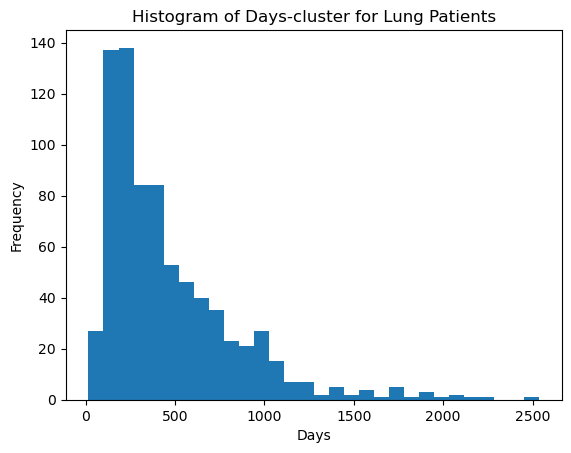

795.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   738.0                   885.0


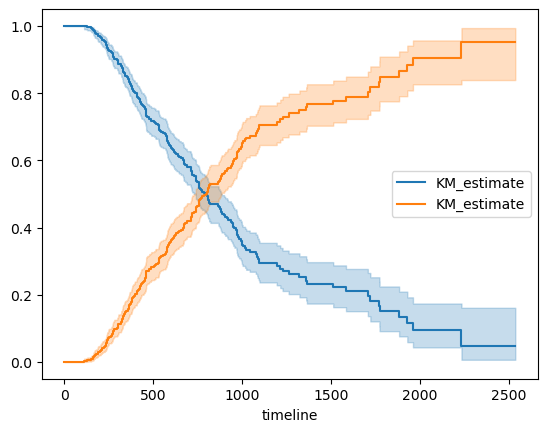

In [31]:
#                                     2- Fusing to SNF
fused_network, best, second = SNF([ndf, cdf], 'euclidean')

#                                     3-  Clustering
from sklearn.cluster import spectral_clustering
lung_labels = spectral_clustering(fused_network, n_clusters= 4)


lung_All     = {'vha_id': Lung_patients    , 'cluster': list(lung_labels), 'cancer_type': Lung_cancer_type }
df_lung = pd.DataFrame(lung_All)

survival0 = pd.read_csv('data/survival.csv')
Lung_survival = pd.merge(df_lung, survival0, on='vha_id')
print(Lung_survival.head())
histo(Lung_survival, 'Lung')



Number of patients in cluser 0 = 547
Number of patients in cluser 1 = 65
Number of patients in cluser 2 = 161
716.0
     SCLC_lower_0.95  SCLC_upper_0.95
0.5            590.0            970.0
P-value (0,1) =  0.0007351651191957134
P-value (0,2) =  0.8610346077055308
P-value (1,2) =  0.0008006640525357157


,vha_id,cluster,cancer_type,state,firstVisit,lastVisit,Days
0,506-NSCLC-01,0,NSCLC,0,11/18/2009,5/5/2010,168
1,506-NSCLC-02,1,NSCLC,0,11/10/2009,5/9/2010,180
2,506-NSCLC-03,1,NSCLC,0,12/9/2009,8/28/2010,262
3,506-NSCLC-04,2,NSCLC,0,11/18/2009,11/21/2010,368
4,506-NSCLC-05,3,NSCLC,1,12/17/2009,1/15/2011,394


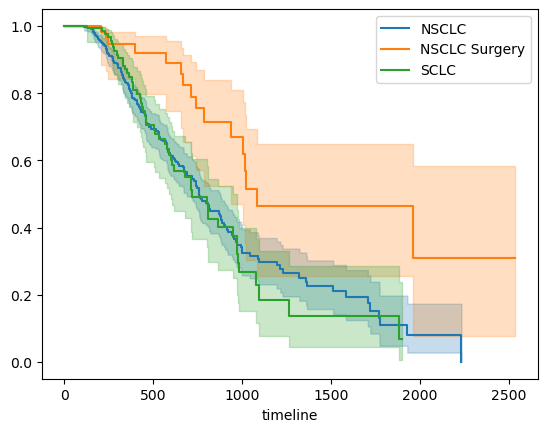

In [28]:
groups = dict(tuple(Lung_survival.groupby('cancer_type')))
groups = [groups[i] for i in groups]
groups_details(groups, ['NSCLC', 'NSCLC Surgery', 'SCLC'])
groups[0].head()